In [88]:
import sys, os
os.environ['JAX_PLATFORMS'] = 'cpu'

import jax
from typing import Dict
import jax.numpy as jnp
import optax
import numpy as np
import math
from matplotlib import pyplot as plt
from jax_tqdm import scan_tqdm
from functools import partial
from jax.tree_util import tree_map
from dataclasses import dataclass
import eindex.array_api as EX
import einops

from jaxtorch import nn
from jaxtorch import PRNG, Context
import jaxtorch

from ngp.optim import SpaceItem, Optim
from ngp.util import Partial

import optuna

In [89]:
# SWEEP_NAME='21-wooden-sweep'
# study = optuna.create_study(
#     study_name=SWEEP_NAME,
#     load_if_exists=True,
#     storage="sqlite:///../vqgan-jax/optuna.db",
#     direction="minimize",
#     sampler=optuna.samplers.GPSampler(),
# )

# pars = list(study.trials[0].params.keys())
# dists = study.trials[0].distributions
# trials = [trial for trial in study.trials if trial.state==1]
# all_y = jnp.array([trial.value for trial in trials])
# max_y = jnp.max(all_y[jnp.isfinite(all_y)])
import json
with open('../vqgan-jax/trials.json', 'r') as fp:
    trials = json.load(fp)
    all_y = jnp.array([trial[1] for trial in trials])
    max_y = jnp.max(all_y[jnp.isfinite(all_y)])

@dataclass
class Trial:
    params: Dict[str, float]
    value: float

trials = [Trial(params, value) for params, value in trials]
pars = list(trials[0].params.keys())

In [90]:
MODS = [
    "wte",
    "wpe",
    "wae",
    ".attn.q_proj",
    ".attn.k_proj",
    ".attn.v_proj",
    ".attn.c_proj",
    ".cross_attn.q_proj",
    ".cross_attn.o_proj",
    ".cross_attn.k_clip",
    ".cross_attn.v_clip",
    ".cross_attn.k_tags",
    ".cross_attn.v_tags",
    ".ffn.up_proj",
    ".ffn.up_gate",
    ".ffn.down_proj",
    "lm_head",
]
space = [SpaceItem('max_lr', 1e-3, 1.0, log=True)]
for mod in MODS:
    space.append(SpaceItem(mod, 0.1, 10.0, log=True))
opt = Optim(space, objective='min', heuristic='ei')
# opt = Optim([SpaceItem(k, dists[k].low, dists[k].high, log=True)for k in pars])
for trial in trials:
    params = trial.params
    value = jnp.where(jnp.isfinite(trial.value), trial.value, max_y)
    opt.notify(params, value)

In [91]:
opt.infer()

Adaptive HMC warmup: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Finished first warmup with ε=[0.00572237 0.00247708 0.00572237 0.00572237] and L=[2000 1818 1878 1798], d=[48.10812  22.496613 69.391014 31.394674], logp=[-129.25223   -64.5853   -142.66945  -111.333664]
Starting initial chain for mass adaptation...


Running for 100 iterations: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


Updated mass metric.
new metric: DictionaryMetric(metrics={'log_sigma': ScalarMetric(a=Array([0.06998897, 0.07039059, 0.06993749, 0.07103033], dtype=float32)), 'params': DictionaryMetric(metrics={'0.bias': ScalarMetric(a=Array([0.02449267, 0.01337836, 0.01845902, 0.01757162], dtype=float32)), '0.weight': ScalarMetric(a=Array([0.03533854, 0.01798946, 0.0265017 , 0.0249698 ], dtype=float32)), '2.bias': ScalarMetric(a=Array([0.00401828, 0.00333023, 0.00411643, 0.00397794], dtype=float32)), '2.weight': ScalarMetric(a=Array([0.00417385, 0.00350452, 0.00428636, 0.00417513], dtype=float32))})})


Adaptive HMC warmup: 100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


Finished second warmup with ε=[0.12328471 0.2477077  0.16297504 0.18738173] and L=[1919  607 1899 1455], d=[2588.984  8161.028  3189.0044 5215.1074], logp=[ -98.75432  -87.04183  -82.33183 -104.96063]
Finally sampling...


Running for 100 iterations: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]

acceptance rate: 0.6856045


In [92]:
jnp.exp(opt.fitted.chains['log_sigma'].mean())

Array(0.0351242, dtype=float32)

/tmp/ipykernel_1391601/3877152412.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


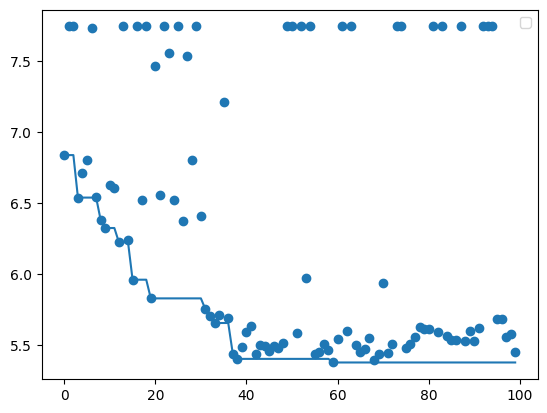

In [93]:
values = [trial.value for trial in opt.trials]
minvalues = [min(values[:i]) for i in range(1, len(values)+1)]
plt.scatter(np.arange(len(values)), values)
plt.plot(np.arange(len(values)), minvalues)
plt.legend()
plt.show()

Suggested best params: {'max_lr': Array(0.13466978, dtype=float32), 'wte': Array(1.9253587, dtype=float32), 'wpe': Array(0.73558414, dtype=float32), 'wae': Array(0.29619756, dtype=float32), '.attn.q_proj': Array(7.7345715, dtype=float32), '.attn.k_proj': Array(2.990798, dtype=float32), '.attn.v_proj': Array(0.6899952, dtype=float32), '.attn.c_proj': Array(0.5051375, dtype=float32), '.cross_attn.q_proj': Array(0.5564976, dtype=float32), '.cross_attn.o_proj': Array(1.6285009, dtype=float32), '.cross_attn.k_clip': Array(0.55298996, dtype=float32), '.cross_attn.v_clip': Array(0.25015962, dtype=float32), '.cross_attn.k_tags': Array(0.82748353, dtype=float32), '.cross_attn.v_tags': Array(0.11011275, dtype=float32), '.ffn.up_proj': Array(4.9830976, dtype=float32), '.ffn.up_gate': Array(9.748686, dtype=float32), '.ffn.down_proj': Array(10., dtype=float32), 'lm_head': Array(10., dtype=float32)}


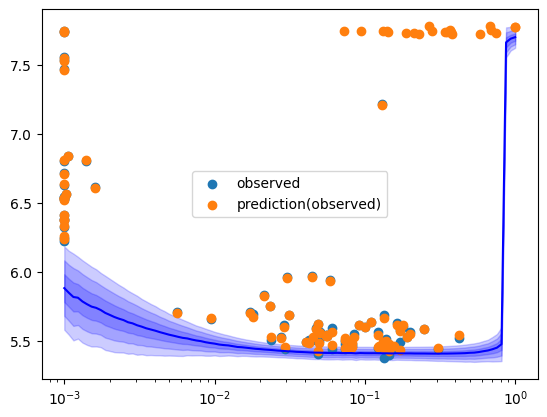

In [94]:
params = opt.suggestbest({})
print('Suggested best params:', params)

key = 'max_lr'

xs = jnp.linspace(0, 1, 100)
xs = opt.space[key].denormalize(xs)
def pred(x):
    params = opt.suggestbest({key: x}, method='cma-es')
    mean, std = opt.fitted.predict(opt.space.normalize(params)[None])
    return mean.squeeze(), std.squeeze()
means, stds = jax.vmap(pred)(xs)
plt.xscale('log')
plt.plot(xs, means, color='blue')
plt.fill_between(xs, means - stds, means + stds, alpha=0.2, color='blue')
plt.fill_between(xs, means - 2*stds, means + 2*stds, alpha=0.2, color='blue')
plt.fill_between(xs, means - 3*stds, means + 3*stds, alpha=0.2, color='blue')
plt.scatter([t.params[key] for t in trials], [t.value for t in trials], label='observed')
plt.scatter([t.params[key] for t in trials], [opt.fitted.predict(opt.space.normalize(t.params))[0] for t in trials], label='prediction(observed)')

plt.legend()
plt.show()

(10, 10) (10, 10) (10, 10)


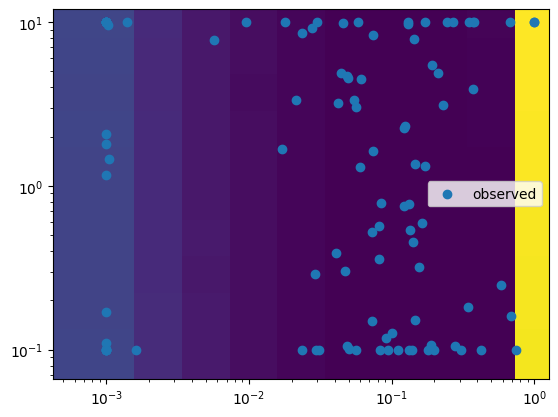

In [95]:
key1 = 'max_lr'
key2 = 'wpe'

xs = jnp.linspace(0, 1, 10)
ys = jnp.linspace(0, 1, 10)
xs = opt.space[key1].denormalize(xs)
ys = opt.space[key2].denormalize(ys)
X, Y = jnp.meshgrid(xs, ys)
@jax.jit
def pred(x, y):
    params = opt.suggestbest({key1: x, key2: y}, method='cma-es')
    mean, std = opt.fitted.predict(opt.space.normalize(params)[None])
    return mean.squeeze(), std.squeeze()
pred = jax.vmap(pred)
pred = jax.vmap(pred)
means, stds = pred(X, Y)
plt.xscale('log')
plt.yscale('log')
print(X.shape, Y.shape, means.shape)
plt.pcolormesh(X, Y, means, 
                    shading='auto',
                    cmap='viridis')
# plt.contour(X, Y, means,
#                      levels=15,  # number of contour lines
#                      cmap='viridis')
plt.scatter([t.params[key1] for t in trials], [t.params[key2] for t in trials], label='observed')

plt.legend()
plt.show()

In [96]:
params = opt.suggestbest({})
key1 = 'max_lr'
for key2 in params.keys():
    if key2 != key1:
        def fx(x):
            pval = dict(params)
            pval[key1] = x
            return opt.fitted.predict(opt.space.normalize(pval))[0]
        def fy(y):
            pval = dict(params)
            pval[key2] = y
            return opt.fitted.predict(opt.space.normalize(pval))[0]
        def fxy(x, y):
            pval = dict(params)
            pval[key1] = x
            pval[key2] = y
            return opt.fitted.predict(opt.space.normalize(pval))[0]

        def interaction(x, y):
            dxx = jax.grad(jax.grad(fx))(x)
            dyy = jax.grad(jax.grad(fy))(y)
            dxy = jax.grad(partial(jax.grad(fxy),x))(y)
            return jnp.abs(dxy) / jnp.sqrt(jnp.abs(dxx) * jnp.abs(dyy))
        print(key1, key2, interaction(params[key1], params[key2]))

# print(interaction(params[key1], params[key2]))

max_lr wte 0.20567732
max_lr wpe 1.460272
max_lr wae 0.7296042
max_lr .attn.q_proj 0.27856386
max_lr .attn.k_proj 0.43461126
max_lr .attn.v_proj 0.59753895
max_lr .attn.c_proj 0.71529794
max_lr .cross_attn.q_proj 0.2647353
max_lr .cross_attn.o_proj 0.00970575
max_lr .cross_attn.k_clip 1.5995307
max_lr .cross_attn.v_clip 0.28429735
max_lr .cross_attn.k_tags 0.10104643
max_lr .cross_attn.v_tags 0.7188893
max_lr .ffn.up_proj 0.021853529
max_lr .ffn.up_gate 0.1696938
max_lr .ffn.down_proj 0.077930965
max_lr lm_head 0.1958045
